In [40]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import urllib

In [41]:
def repeat_pattern(X,Y,Z):
    flag_ = np.where((X>0)&(Y>0))
    flag1 = np.where((X>0)&(Y<0))
    flag1 = tuple((flag1[0][::-1],flag1[1]))
    Z[flag1] = Z[flag_]
    flag2 = np.where((X<0)&(Y>0))
    flag2 = tuple((flag2[0],flag2[1][::-1]))
    Z[flag2] = Z[flag_]
    flag3 = np.where((X<0)&(Y<0))
    flag3 = tuple((flag3[0][::-1],flag3[1][::-1]))
    Z[flag3] = Z[flag_]
    return Z


In [42]:
def get_property(mat,energy):
    url = "http://henke.lbl.gov/cgi-bin/pert_cgi.pl"
    data = {'Element':str(mat), 'Energy':str(energy), 'submit':'Submit Query'}
    data = urllib.parse.urlencode(data)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    resp = urllib.request.urlopen(req)
    respDat = resp.read()
    response = respDat.split()
    d =  b'g/cm^3<li>Delta'
    i = response.index(d)
    delta = str(response[i+2])[:str(response[i+2]).index('<li>Beta')][2:]
    beta = str(response[i+4])[2:-1]
    return float(delta),float(beta)


In [43]:
@njit   # equivalent to "jit(nopython=True)".
def partial_fill(x,y,step,r1,r2,n):
    x_ = np.linspace(x-step/2,x+step/2,n)
    y_ = np.linspace(y-step/2,y+step/2,n)
    cnts = 0
    for i in range(n):
        for j in range(n):
            z = (x_[i] * x_[i] + y_[j] * y_[j])
            if r1*r1 < z < r2*r2:
                cnts += 1
    fill_factor = cnts/(n*n)
    return fill_factor

In [44]:
#find the radius of the nth zone
def zone_radius(n,f,wavel):
    return np.sqrt(n*wavel*f + ((n*wavel)/2)**2)

In [45]:
def make_ring(X,Y,flag,r1,r2,n):
    z = np.zeros(np.shape(X))
    Z = np.sqrt(X**2+Y**2)
    for l in range(len(flag[0])):
        i = flag[0][l]
        j = flag[1][l]
        if 0.75*r1< Z[i][j] < 1.25*r2:
            x1 = X[i][j]
            y1 = Y[i][j]
            z[i][j] = partial_fill(x1,y1,step,r1,r2,n)
    z[tuple((flag[1],flag[0]))] = z[tuple((flag[0],flag[1]))]
    return z

In [46]:
mat = 'Ni'
energy = 520                   #Energy in EV
f = 0.0012096774193548385          #focal length in meters 
wavel = (1239.84/energy)*10**(-9)  #Wavelength in meters
delta,beta = get_property(mat,energy)

N = 2500
n = 250
zp = np.zeros((N,N))
x =  np.linspace(-75e-6,75e-6,N)
X,Y = np.meshgrid(x,x)
step = x[-1]-x[-2]
flag = np.where((X>0)&(Y>0)&(X>=Y))

N = 625 #number of zones
radius = np.zeros(N)

In [47]:
for k in range(N):
    radius[k] = zone_radius(k,f,wavel)

In [48]:
#2D ZP
zp = np.zeros(np.shape(X))
for i in range(50):
    if i%2 == 1 :
        r1 = radius[i-1]
        r2 = radius[i]
        ring = make_ring(X,Y,flag,r1,r2,500)
        zp+=ring
zp = repeat_pattern(X,Y,zp)

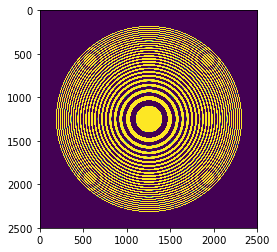

In [32]:
plt.imshow(zp)
plt.show()